In [1]:
!pip install keras_tuner

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


# Data cleaning

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import config
jdbc_url=config.DB_PATH
# Create Engine
engine = create_engine(jdbc_url)
conn = engine.connect()
data = pd.read_sql("SELECT * FROM historical", conn)
data.head()

,index,crypto,time,open,high,low,close,volume,trade
0,0,bitcoin_usdt,1.511914e+09,9896.79000000,11300.03000000,8520.00000000,9687.88000000,13352.53871500,8662.63236200
1,1,bitcoin_usdt,1.512000e+09,9687.88000000,10900.00000000,8850.80000000,9838.96000000,9389.57432900,5360.66024200
2,2,bitcoin_usdt,1.512086e+09,9837.00000000,10898.00000000,9380.00000000,10782.99000000,6134.92363300,3269.86858800
3,3,bitcoin_usdt,1.512173e+09,10775.04000000,11190.00000000,10620.00000000,10890.01000000,4765.43975700,2390.19427500
4,4,bitcoin_usdt,1.512259e+09,10902.69000000,11825.00000000,10500.00000000,11165.41000000,5346.63652400,2574.24618700


In [3]:
eth_df = data[data['crypto'].str.contains('ethereum_usdt',case=False, na=False)]
eth_df.shape

(1462, 9)

In [4]:
df1 = eth_df.reset_index()['close']

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
eth_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))
eth_scaled.shape

(1462, 1)

In [6]:
#split dataset into train and test
train_size = int(len(eth_scaled)*0.70)
test_size = len(eth_scaled) - train_size
train_data, test_data = eth_scaled[0:train_size,:],eth_scaled[train_size:len(eth_scaled),:1]
print(train_data.shape, test_data.shape)

(1023, 1) (439, 1)


In [7]:
def create_data(data, timestep):
  x_data = []
  y_data = []

  for i in range(timestep, data.size):
    x_data.append(data[i-timestep:i, 0])
    y_data.append(data[i, 0])
  return np.array(x_data), np.array(y_data)

In [8]:
#assuming the timestep of 150 days, applying the function to our train and test data
timestep = 150
X_train, y_train = create_data(train_data, timestep)
X_test, y_test = create_data(test_data,timestep)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(873, 150)
(873,)
(289, 150)
(289,)


(None, None)

In [9]:
#RNN expects the data being fed to be transformed from 2d array to 3d
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(873, 150, 1)
(873,)
(289, 150, 1)
(289,)


(None, None)

# LSTM model

We use Sequential module from Keras that allows to create a Neural Network object with sequential layers. Then, we add LSTM layers and given that predicting a price of a coin is a quite complex task we use 50 LSTM units per LSTM layer and we use multiple LSTM layers. We also add a Dropout layer, for regularization to ignore part of the neurons in the LSTM layers and avoid overfitting. Finally, we use the Dense module to add an output layer

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.metrics import MeanSquaredError

regressor = Sequential()
regressor.add(LSTM(50, return_sequences=True, input_shape=(150,1)))
regressor.add(LSTM(50, return_sequences=True))
regressor.add(LSTM(50))
regressor.add(Dense(1))
regressor.compile(loss='mean_squared_error', optimizer='adam')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 150, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [13]:
def create_model(LSTMtune):
  LSTM_tune = Sequential()

  # LSTM layer 1
  units_param = LSTMtune.Int('first_units', min_value=1, max_value=50)
  LSTM_tune.add(LSTM(units = units_param, return_sequences=True, input_shape = (X_train.shape[1], 1)))
  LSTM_tune.add(Dropout(0.2))

  for i in range(LSTMtune.Int('num_layers', 1, 6)):
    units_param = LSTMtune.Int('units_'+str(i), min_value=1, max_value=50)
    LSTM_tune.add(LSTM(units = units_param, return_sequences=True))
    LSTM_tune.add(Dropout(0.2))

# LSTM layer
  units_param = LSTMtune.Int('last_units', min_value=1, max_value=50)
  LSTM_tune.add(LSTM(units = units_param))
  LSTM_tune.add(Dropout(0.2))

# Fully connected layer
  LSTM_tune.add(Dense(units = 1))

# Compiling the RNN
  LSTM_tune.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=["mean_squared_error"])

  return LSTM_tune
#Fitting the RNN model

In [14]:
import keras_tuner
tuner = keras_tuner.Hyperband(
    create_model,
    objective=keras_tuner.Objective("mean_squared_error", direction="min"),
    max_epochs=100,
    hyperband_iterations=1
)

In [15]:
tuner.search(X_train, y_train, validation_data=(X_test,y_test))

Trial 254 Complete [00h 09m 30s]
mean_squared_error: 5.315231464919634e-05

Best mean_squared_error So Far: 3.336598092573695e-05
Total elapsed time: 04h 13m 04s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_LSTM=tuner.get_best_hyperparameters(1)[0]
LSTM_best = tuner.hypermodel.build(best_LSTM)
best_LSTM.values

{'first_units': 35,
 'num_layers': 1,
 'units_0': 36,
 'last_units': 36,
 'units_1': 2,
 'units_2': 49,
 'units_3': 34,
 'units_4': 40,
 'units_5': 4,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '6e80e5c584d74564b25e41db143172c1'}

In [18]:
regressor.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 7s 271ms/step - loss: 7.0949e-04 - val_loss: 0.0599
Epoch 2/100
14/14 [==============================] - 4s 257ms/step - loss: 1.5974e-04 - val_loss: 0.0281
Epoch 3/100
14/14 [==============================] - 3s 198ms/step - loss: 8.5091e-05 - val_loss: 0.0181
Epoch 4/100
14/14 [==============================] - 3s 203ms/step - loss: 6.7884e-05 - val_loss: 0.0211
Epoch 5/100
14/14 [==============================] - 3s 209ms/step - loss: 5.9470e-05 - val_loss: 0.0126
Epoch 6/100
14/14 [==============================] - 3s 195ms/step - loss: 5.3839e-05 - val_loss: 0.0148
Epoch 7/100
14/14 [==============================] - 3s 198ms/step - loss: 5.0347e-05 - val_loss: 0.0205
Epoch 8/100
14/14 [==============================] - 3s 199ms/step - loss: 4.7769e-05 - val_loss: 0.0108
Epoch 9/100
14/14 [==============================] - 3s 194ms/step - loss: 4.4558e-05 - val_loss: 0.0087
Epoch 10/100
14/14 [==============================] - 3

14/14 [==============================] - 3s 210ms/step - loss: 2.0779e-05 - val_loss: 0.0036
Epoch 79/100
14/14 [==============================] - 3s 199ms/step - loss: 1.8455e-05 - val_loss: 0.0033
Epoch 80/100
14/14 [==============================] - 3s 203ms/step - loss: 1.7807e-05 - val_loss: 0.0039
Epoch 81/100
14/14 [==============================] - 3s 200ms/step - loss: 1.7266e-05 - val_loss: 0.0046
Epoch 82/100
14/14 [==============================] - 3s 196ms/step - loss: 1.7390e-05 - val_loss: 0.0037
Epoch 83/100
14/14 [==============================] - 3s 198ms/step - loss: 1.6269e-05 - val_loss: 0.0024
Epoch 84/100
14/14 [==============================] - 3s 196ms/step - loss: 1.6917e-05 - val_loss: 0.0035
Epoch 85/100
14/14 [==============================] - 3s 196ms/step - loss: 1.6321e-05 - val_loss: 0.0032
Epoch 86/100
14/14 [==============================] - 3s 196ms/step - loss: 1.5716e-05 - val_loss: 0.0043
Epoch 87/100
14/14 [==============================] - 3s 19

In [21]:
LSTM_best.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 198ms/step - loss: 2.0435e-04 - mean_squared_error: 2.0435e-04 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 2/100
14/14 [==============================] - 3s 196ms/step - loss: 1.2788e-04 - mean_squared_error: 1.2788e-04 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 3/100
14/14 [==============================] - 3s 199ms/step - loss: 1.0013e-04 - mean_squared_error: 1.0013e-04 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/100
14/14 [==============================] - 3s 202ms/step - loss: 9.9160e-05 - mean_squared_error: 9.9160e-05 - val_loss: 0.0199 - val_mean_squared_error: 0.0199
Epoch 5/100
14/14 [==============================] - 3s 198ms/step - loss: 8.6504e-05 - mean_squared_error: 8.6504e-05 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 6/100
14/14 [==============================] - 3s 201ms/step - loss: 8.5880e-05 - mean_squared_error: 8.5880e-05 - val_loss: 0.0140 - val_m

Epoch 49/100
14/14 [==============================] - 3s 201ms/step - loss: 4.3159e-05 - mean_squared_error: 4.3159e-05 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 50/100
14/14 [==============================] - 3s 199ms/step - loss: 3.8817e-05 - mean_squared_error: 3.8817e-05 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 51/100
14/14 [==============================] - 3s 199ms/step - loss: 3.9749e-05 - mean_squared_error: 3.9749e-05 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 52/100
14/14 [==============================] - 3s 199ms/step - loss: 4.8011e-05 - mean_squared_error: 4.8011e-05 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 53/100
14/14 [==============================] - 3s 199ms/step - loss: 4.6433e-05 - mean_squared_error: 4.6433e-05 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 54/100
14/14 [==============================] - 3s 198ms/step - loss: 4.6212e-05 - mean_squared_error: 4.6212e-05 - val_loss: 0.0041 -

14/14 [==============================] - 3s 198ms/step - loss: 3.5590e-05 - mean_squared_error: 3.5590e-05 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 97/100
14/14 [==============================] - 3s 198ms/step - loss: 4.0144e-05 - mean_squared_error: 4.0144e-05 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 98/100
14/14 [==============================] - 3s 200ms/step - loss: 3.5742e-05 - mean_squared_error: 3.5742e-05 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 99/100
14/14 [==============================] - 3s 198ms/step - loss: 3.9353e-05 - mean_squared_error: 3.9353e-05 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 100/100
14/14 [==============================] - 3s 201ms/step - loss: 3.9942e-05 - mean_squared_error: 3.9942e-05 - val_loss: 0.0041 - val_mean_squared_error: 0.0041


## Prediction

In [22]:
#make predictions using train and test data
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [23]:
train_pred_tune = LSTM_best.predict(X_train)
test_pred_tune = LSTM_best.predict(X_test)

In [24]:
#tranformation to original form and making the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [25]:
train_pred_tune = scaler.inverse_transform(train_pred_tune)
test_pred_tune = scaler.inverse_transform(test_pred_tune)

In [26]:
y_train_reshape = y_train.reshape(-1, 1)
y_test_reshape = y_test.reshape(-1, 1)
y_train_inverse = scaler.inverse_transform(y_train_reshape)
y_test_inverse = scaler.inverse_transform(y_test_reshape)

In [27]:
#check the performance of the model prediction
import math
from sklearn.metrics import mean_squared_error, r2_score
print(f"Train RMSE:{math.sqrt(mean_squared_error(y_train_inverse,train_predict))}")
print(f"Train MSE:{mean_squared_error(y_train_inverse,train_predict)}")
print("-------------------------------")
print(f"Test RMSE:{math.sqrt(mean_squared_error(y_test_inverse,test_predict))}")
print(f"Test MSE:{mean_squared_error(y_test_inverse,test_predict)}")
print(f"R2 score:{r2_score(y_test_inverse,test_predict)}")

Train RMSE:15.892714065371969
Train MSE:252.57836036367203
-------------------------------
Test RMSE:244.35037085537823
Test MSE:59707.103737160876
R2 score:0.925749907233176


In [28]:
print(f"Train RMSE:{math.sqrt(mean_squared_error(y_train_inverse,train_pred_tune))}")
print(f"Train MSE:{mean_squared_error(y_train_inverse,train_pred_tune)}")
print("-------------------------------")
print(f"Test RMSE:{math.sqrt(mean_squared_error(y_test_inverse,test_pred_tune))}")
print(f"Test MSE:{mean_squared_error(y_test_inverse,test_pred_tune)}")
print(f"R2 score:{r2_score(y_test_inverse,test_pred_tune)}")

Train RMSE:22.681857033269978
Train MSE:514.4666384776988
-------------------------------
Test RMSE:302.70577078148403
Test MSE:91630.78366441235
R2 score:0.8860505072004533


## Charts

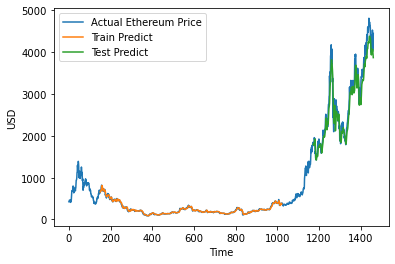

In [30]:
#create empty numpy array then add the train and test data, this way we can shape the data
import matplotlib.pyplot as plt
timepoints = 150

train_predict_plot=np.empty_like(eth_scaled)
train_predict_plot[:,:]=np.nan
train_predict_plot[timepoints:len(train_predict)+timepoints,:]=train_predict
#shift test predictions for plotting
test_predict_plot=np.empty_like(eth_scaled)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+(timepoints*2):len(eth_scaled),:]=test_predict
#plot baseline and prediction
plt.plot(scaler.inverse_transform(eth_scaled), label= 'Actual Ethereum Price')
plt.plot(train_predict_plot, label= 'Train Predict')
plt.plot(test_predict_plot, label= 'Test Predict')
plt.xlabel("Time")
plt.ylabel("USD")
plt.legend()
plt.show()

## Predict for the future

In [31]:
x_input=test_data[289:].reshape(1,-1)
temp_input=list(x_input)
print(x_input.shape)
temp_input=temp_input[0].tolist()
len(temp_input)

(1, 150)


150

In [32]:
# demonstrate prediction for next 90 days
output=[]
n_steps=150
i=0
while(i<90):
    
    if(len(temp_input)>150):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        prediction = regressor.predict(x_input, verbose=0)
        print("{} day output {}".format(i,prediction))
        temp_input.extend(prediction[0].tolist())
        temp_input=temp_input[1:]
        output.extend(prediction.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        prediction = regressor.predict(x_input, verbose=0)
        temp_input.extend(prediction[0].tolist())
        output.extend(prediction.tolist())
        i=i+1

1 day input [0.47392585 0.44722092 0.47388564 0.4726304  0.43024457 0.43673453
 0.42905072 0.43535017 0.4123051  0.39295164 0.40447312 0.38858267
 0.37942772 0.3843661  0.38268328 0.36725004 0.36032827 0.40466786
 0.41081914 0.43192104 0.44472738 0.44579423 0.45389927 0.46901499
 0.46931345 0.48667505 0.5033741  0.51803049 0.52324617 0.5340924
 0.51337152 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039
 0.65127365 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999
 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487
 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368
 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281
 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742

5 day output [[0.70601773]]
6 day input [0.43673453 0.42905072 0.43535017 0.4123051  0.39295164 0.40447312
 0.38858267 0.37942772 0.3843661  0.38268328 0.36725004 0.36032827
 0.40466786 0.41081914 0.43192104 0.44472738 0.44579423 0.45389927
 0.46901499 0.46931345 0.48667505 0.5033741  0.51803049 0.52324617
 0.5340924  0.51337152 0.55903832 0.58067364 0.59434573 0.6512292
 0.6198039  0.65127365 0.64728146 0.65126942 0.62702414 0.68552269
 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918
 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183
 0.63702368 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653
 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974
 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677
 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972
 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713
 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468
 0.6828958  0.69937471 0

13 day output [[0.5968348]]
14 day input [0.3843661  0.38268328 0.36725004 0.36032827 0.40466786 0.41081914
 0.43192104 0.44472738 0.44579423 0.45389927 0.46901499 0.46931345
 0.48667505 0.5033741  0.51803049 0.52324617 0.5340924  0.51337152
 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039  0.65127365
 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999 0.68229888
 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487 0.66459013
 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368 0.67517812
 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281 0.78363412
 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146
 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089
 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629
 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774 0.62986271
 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471
 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618
 0.73897067 0.7049756

22 day output [[0.44502488]]
23 day input [0.45389927 0.46901499 0.46931345 0.48667505 0.5033741  0.51803049
 0.52324617 0.5340924  0.51337152 0.55903832 0.58067364 0.59434573
 0.6512292  0.6198039  0.65127365 0.64728146 0.65126942 0.62702414
 0.68552269 0.67299999 0.68229888 0.64831231 0.61977639 0.62037543
 0.65626918 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157
 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986  0.66590464
 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834
 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727
 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.8029410

30 day output [[0.36896107]]
31 day input [0.51337152 0.55903832 0.58067364 0.59434573 0.6512292  0.6198039
 0.65127365 0.64728146 0.65126942 0.62702414 0.68552269 0.67299999
 0.68229888 0.64831231 0.61977639 0.62037543 0.65626918 0.67758487
 0.66459013 0.66767424 0.68530255 0.65341157 0.6653183  0.63702368
 0.67517812 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281
 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958
 0.69937471 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836
 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128
 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508 0.80294101
 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756
 0.85681022 0.81246005

38 day output [[0.3092997]]
39 day input [0.65126942 0.62702414 0.68552269 0.67299999 0.68229888 0.64831231
 0.61977639 0.62037543 0.65626918 0.67758487 0.66459013 0.66767424
 0.68530255 0.65341157 0.6653183  0.63702368 0.67517812 0.6690459
 0.6645986  0.66590464 0.70814653 0.79231281 0.78363412 0.81587013
 0.80473814 0.81844834 0.81346974 0.70928323 0.72292146 0.70724268
 0.66150603 0.67385727 0.70285677 0.67769706 0.70924089 0.74716884
 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629 0.5677424
 0.63357761 0.64957601 0.60216713 0.60072774 0.62986271 0.60154481
 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471 0.70571862
 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067
 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915
 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737
 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005
 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577
 0.95668491 0.94164963 

46 day output [[0.28004056]]
47 day input [0.65626918 0.67758487 0.66459013 0.66767424 0.68530255 0.65341157
 0.6653183  0.63702368 0.67517812 0.6690459  0.6645986  0.66590464
 0.70814653 0.79231281 0.78363412 0.81587013 0.80473814 0.81844834
 0.81346974 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727
 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586
 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931
 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963
 0.92935553 0.93861844 0.95864079 1.         0.98398677 0.96206781
 0.98116514 0.9698320

54 day output [[0.25921375]]
55 day input [0.67517812 0.6690459  0.6645986  0.66590464 0.70814653 0.79231281
 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974 0.70928323
 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677 0.67769706
 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972 0.68685624
 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774
 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958
 0.69937471 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836
 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128
 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508 0.80294101
 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756
 0.85681022 0.81246005 0.88951404 0.91763931 0.89727405 0.88976593
 0.8965861  0.95383577 0.95668491 0.94164963 0.92935553 0.93861844
 0.95864079 1.         0.98398677 0.96206781 0.98116514 0.96983206
 0.96534878 0.96158519 0.94830893 0.87337169 0.88989082 0.82831452
 0.89136408 0.9162168

59 day output [[0.2507665]]
60 day input [0.79231281 0.78363412 0.81587013 0.80473814 0.81844834 0.81346974
 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727 0.70285677
 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254  0.70950972
 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601 0.60216713
 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953 0.61742468
 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541 0.73898548
 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889 0.72132543
 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266 0.77498508
 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586 0.84639792
 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931 0.89727405
 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963 0.92935553
 0.93861844 0.95864079 1.         0.98398677 0.96206781 0.98116514
 0.96983206 0.96534878 0.96158519 0.94830893 0.87337169 0.88989082
 0.82831452 0.89136408 0.91621686 0.88364852 0.84716842 0.90082172
 0.88598753 0.9400684

64 day output [[0.24174169]]
65 day input [0.81346974 0.70928323 0.72292146 0.70724268 0.66150603 0.67385727
 0.70285677 0.67769706 0.70924089 0.74716884 0.73752281 0.7019254
 0.70950972 0.68685624 0.61248629 0.5677424  0.63357761 0.64957601
 0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586
 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931
 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963
 0.92935553 0.93861844 0.95864079 1.         0.98398677 0.96206781
 0.98116514 0.96983206 0.96534878 0.96158519 0.94830893 0.87337169
 0.88989082 0.82831452 0.89136408 0.91621686 0.88364852 0.84716842
 0.90082172 0.88598753 0.94006841 0.83769172 0.84914123 0.89136831
 0.92306666 0.8156852

73 day output [[0.22573273]]
74 day input [0.74716884 0.73752281 0.7019254  0.70950972 0.68685624 0.61248629
 0.5677424  0.63357761 0.64957601 0.60216713 0.60072774 0.62986271
 0.60154481 0.57599985 0.58563953 0.61742468 0.6828958  0.69937471
 0.70571862 0.69906778 0.72636541 0.73898548 0.74164836 0.73649618
 0.73897067 0.70497564 0.73204889 0.72132543 0.74587128 0.7846925
 0.80123915 0.79297747 0.79655266 0.77498508 0.80294101 0.86308216
 0.84018737 0.82308614 0.86434586 0.84639792 0.87561756 0.85681022
 0.81246005 0.88951404 0.91763931 0.89727405 0.88976593 0.8965861
 0.95383577 0.95668491 0.94164963 0.92935553 0.93861844 0.95864079
 1.         0.98398677 0.96206781 0.98116514 0.96983206 0.96534878
 0.96158519 0.94830893 0.87337169 0.88989082 0.82831452 0.89136408
 0.91621686 0.88364852 0.84716842 0.90082172 0.88598753 0.94006841
 0.83769172 0.84914123 0.89136831 0.92306666 0.81568521 0.80554813
 0.78169107 0.75427818 0.7284109  0.70601773 0.68747121 0.67233539
 0.65970027 0.64841563

82 day output [[0.20853616]]
83 day input [0.60216713 0.60072774 0.62986271 0.60154481 0.57599985 0.58563953
 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778 0.72636541
 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564 0.73204889
 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747 0.79655266
 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614 0.86434586
 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404 0.91763931
 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491 0.94164963
 0.92935553 0.93861844 0.95864079 1.         0.98398677 0.96206781
 0.98116514 0.96983206 0.96534878 0.96158519 0.94830893 0.87337169
 0.88989082 0.82831452 0.89136408 0.91621686 0.88364852 0.84716842
 0.90082172 0.88598753 0.94006841 0.83769172 0.84914123 0.89136831
 0.92306666 0.81568521 0.80554813 0.78169107 0.75427818 0.7284109
 0.70601773 0.68747121 0.67233539 0.65970027 0.64841563 0.63731349
 0.62540424 0.61201119 0.59683478 0.57993954 0.56169593 0.54268426
 0.52358335 0.5050599

87 day output [[0.19896479]]
88 day input [0.58563953 0.61742468 0.6828958  0.69937471 0.70571862 0.69906778
 0.72636541 0.73898548 0.74164836 0.73649618 0.73897067 0.70497564
 0.73204889 0.72132543 0.74587128 0.7846925  0.80123915 0.79297747
 0.79655266 0.77498508 0.80294101 0.86308216 0.84018737 0.82308614
 0.86434586 0.84639792 0.87561756 0.85681022 0.81246005 0.88951404
 0.91763931 0.89727405 0.88976593 0.8965861  0.95383577 0.95668491
 0.94164963 0.92935553 0.93861844 0.95864079 1.         0.98398677
 0.96206781 0.98116514 0.96983206 0.96534878 0.96158519 0.94830893
 0.87337169 0.88989082 0.82831452 0.89136408 0.91621686 0.88364852
 0.84716842 0.90082172 0.88598753 0.94006841 0.83769172 0.84914123
 0.89136831 0.92306666 0.81568521 0.80554813 0.78169107 0.75427818
 0.7284109  0.70601773 0.68747121 0.67233539 0.65970027 0.64841563
 0.63731349 0.62540424 0.61201119 0.59683478 0.57993954 0.56169593
 0.54268426 0.52358335 0.5050599  0.4876709  0.47179398 0.45759365
 0.44502488 0.433870

In [33]:
eth_scaled.shape

(1462, 1)

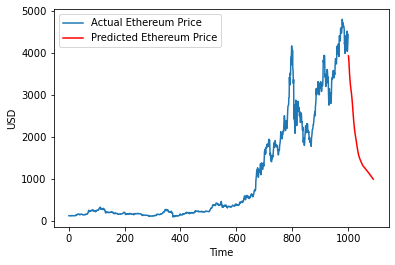

In [34]:
day_new=np.arange(1,1001)
day_pred=np.arange(1001,1091)
plt.plot(day_new,scaler.inverse_transform(eth_scaled[462:]), label = "Actual Ethereum Price")
plt.plot(day_pred,scaler.inverse_transform(output), label="Predicted Ethereum Price", color="red")
plt.xlabel("Time")
plt.ylabel("USD")
plt.legend()
plt.show()